# Transversal Pump

The Hamiltonian is
$$
H_\text{trans} = \frac{p^2}{2m} + V_\text{ext}(x) - \hbar \Delta_\text{c} a^\dagger a + \hbar \eta \cos(kx) (a + a^\dagger) + \hbar U_0 \cos(kx)^2,
$$
where $\Delta_\text{c} = \omega_\text{l} - \omega_\text{c}$, $\eta$ is the pump strength and $U_0$ is the depth of the potential. Note that because $H_\text{trans} \propto \cos(kx) + \cos(kx)^2$, the Hamiltoninan is $\lambda$-periodic.

In [1]:
using QuantumOptics, PyPlot, Printf, LinearAlgebra

We choose a maximum number of photons of $N_\text{cutoff}=16$. If we choose $k=2\pi$, then $\lambda=1$.

In [2]:
# Define Parameters
N_cutoff = 16
xmin = 0
xmax = 1
Nsteps = 32

k = 2*π
ωr = 1

Δc = -300 * ωr
U0 = -100 * ωr;

In [3]:
# Bases
b_position = PositionBasis(xmin, xmax, Nsteps)
b_fock = FockBasis(N_cutoff)

# Operators for atom
p = momentum(b_position)

# Operators for cavity
a = destroy(b_fock) ⊗ one(b_position)
ad = dagger(a);

In [4]:
# Hamiltonian and calculate states
potential = x -> U0*cos(k*x)^2
H_int = (one(b_fock) ⊗ potentialoperator(b_position, potential))*ad*a
H_kin = (one(b_fock) ⊗ p^2) / k^2
H_cavity = -Δc*ad*a

function H(η)
    pump = x -> η*cos(k*x)
    H_pump = (one(b_fock) ⊗ potentialoperator(b_position, pump)) * (a + ad)
    return H_kin + dense(H_int) + H_pump + H_cavity
end;

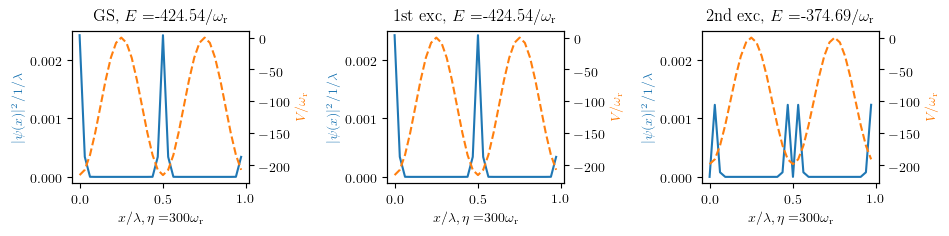

In [13]:
# Plot distributions for first three states

rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")

η = 300 * ωr
E, ψ_states = eigenstates((H(η) + dagger(H(η)))/2, 3);

xpoints = samplepoints(b_position)

fig = figure()

for i in 1:3
    plt_index = 330 + i
    host = fig.add_subplot(plt_index)
    par1 = host.twinx()
    
    pos_dense = ptrace(ψ_states[i], 1)
    density = diag(pos_dense.data)
    ada_exp = expect(ad*a, ψ_states[i])
    apad_exp = expect(a + ad, ψ_states[i])
    pot = @. U0*cos(k*xpoints)^2*real(ada_exp) + η*cos(k*xpoints)*real(apad_exp)
    
    host.set_ylim(-0.0001, 0.0025)
    par1.set_ylim(-228.498505, 10.880881)
    host.plot(xpoints, abs2.(density ./ sqrt(Nsteps)), "C0")
    par1.plot(xpoints, pot, "C1", linestyle="--")
    
    host.set_xlabel(L"x / \lambda, \eta=" * @sprintf("%d", η) * L"\omega_\text{r}")
    host.set_ylabel(L"|\psi(x)|^2 / 1/\lambda")
    par1.set_ylabel(L"V / \omega_\text{r}")
    host.yaxis.label.set_color("C0")
    par1.yaxis.label.set_color("C1")
    
    # Boundaries
#     println("host.set_ylim(" *@sprintf("%.4f", host.get_ylim()[1]) *", " *@sprintf("%.4f", host.get_ylim()[2]) *")")
#     println("par1.set_ylim(" *@sprintf("%.6f", par1.get_ylim()[1]) *", " *@sprintf("%.6f", par1.get_ylim()[2]) *")")
    
    if i == 1
        title("GS, " * L"E=" * @sprintf("%.2f", E[1]) * L"/ \omega_\text{r}")
    elseif i == 2
        title("1st exc, " * L"E=" * @sprintf("%.2f", E[2]) * L"/ \omega_\text{r}")
    else
        title("2nd exc, " * L"E=" * @sprintf("%.2f", E[3]) * L"/ \omega_\text{r}")
    end
end

tight_layout(rect=[0, 0, 1.5, 1.3])

We can see that the ground state and the first excited state have the same energy and thus are degenerate states. The peaks are higher than with longitudinal pumping.

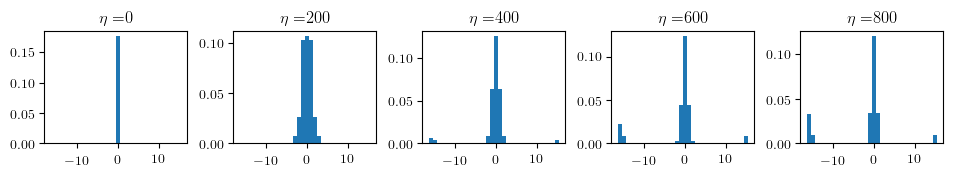

In [6]:
# Plot momentum

rc("text", usetex=true)
rc("font", family="serif")

b_momentum = MomentumBasis(b_position)
Tpx = transform(b_momentum, b_position)

η_arr = [0:200:800;] .* ωr

fig = figure()
for i in 1:size(η_arr)[1]
    plt_index = size(η_arr)[1]*110 + i
    host = fig.add_subplot(plt_index)
    
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    pos_dense = ptrace(ψ_states[1], 1)
    states_p = Tpx * pos_dense
    density_p = diag(states_p.data)

    host.bar([-Nsteps/2:1:Nsteps/2-1;], abs.(density_p), width=1)
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
end

tight_layout(rect=[0, 0, 1.5, 1.6])

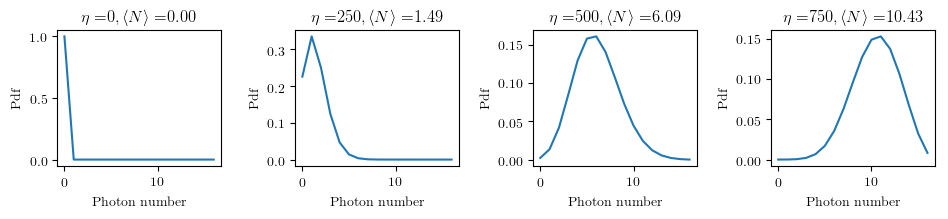

In [7]:
# Plot photon number

rc("text", usetex=true)
rc("font", family="serif")

η_arr = [0:250:750;] .* ωr

fig = figure()
for i in 1:size(η_arr)[1]
    plt_index = size(η_arr)[1]*110 + i
    host = fig.add_subplot(plt_index)
    
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i])))/2, 1);
    photon_dense = ptrace(ψ_states[1], 2)
    density_photon = diag(photon_dense.data)

    host.plot([0:1:16;], density_photon)
    ada_exp = expect(ad*a, ψ_states[1])
    title_string = L"\eta=" * @sprintf("%d", η_arr[i]) *L", \langle N \rangle=" * @sprintf("%.2f", real(ada_exp))
    title(title_string)
    
    host.set_xlabel("Photon number")
    host.set_ylabel("Pdf")
end
tight_layout(rect=[0, 0, 1.5, 1.6])

Longitudinal and transversal photon number densities are the same.

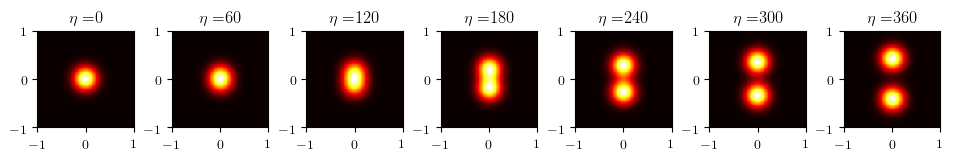

In [8]:
# Qfunc

rc("text", usetex=true)
rc("font", family="serif")

η_arr = [0:60:400;] .* ωr

# Boundary
bdr = 6
xvec = [-bdr:.1:bdr;]
yvec = [-bdr:.1:bdr;]

fig = figure()

for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);

    plt_index = size(η_arr)[1] * 110 + i
    subplot(plt_index)
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    imshow(abs.(husimi_q), cmap="hot", interpolation="nearest", extent=(-1,1,-1,1));
    title_string = L"\eta=" * @sprintf("%d", η_arr[i])
    title(title_string)
end

tight_layout(rect=[0, 0, 1.5, 2]);

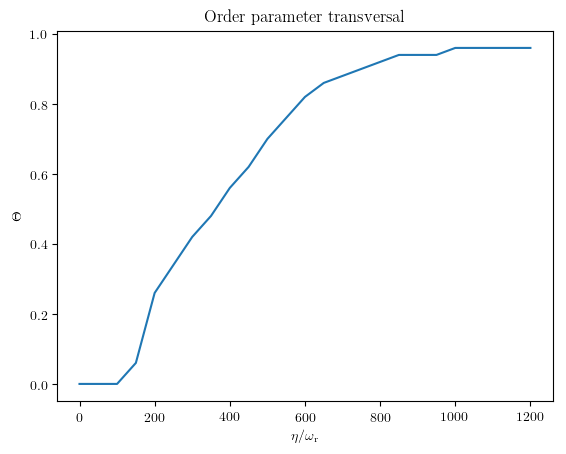

In [9]:
# Plot order parameter
rc("text", usetex=true)
rc("text.latex", preamble= "\\usepackage{amsmath}")
rc("font", family="serif")

η_arr = [0:50:1200;] .* ωr
bdr = 7
step = 0.1
xvec = [-bdr:step:bdr;]
yvec = [-bdr:step:bdr;]

order_param_arr = []
for i in 1:size(η_arr)[1]
    E, ψ_states = eigenstates((H(η_arr[i]) + dagger(H(η_arr[i]))) / 2, 1);
    husimi_q = qfunc(ptrace(ψ_states[1], 2), xvec, yvec)
    husimi_q_sub = husimi_q[1:trunc(Int, bdr/step+1),:]
    temp = abs(findmax(abs.(husimi_q_sub))[2][1] - (bdr/step+1)) / 50
    push!(order_param_arr, temp)
end

plot(η_arr, order_param_arr)
xlabel(L"\eta / \omega_\text{r}")
ylabel(L"\Theta")
title("Order parameter transversal");

There's clearly a threshold at which the order parameter starts to rise quickly.